# Examples for Task Parameterized Gaussian Mixture Models


Load dataset. You can find more details about the dataset at: https://theairlab.org/trajair/


In [5]:
import os
import sys
sys.path.append("/".join(os.getcwd().split("/")[:-1]))


In [6]:
from tpgmm.utils.file_system import load_txt
from tpgmm.utils.casting import ssv_to_ndarray

from tpgmm.utils.plot.plot import plot_trajectories

import numpy as np

from glob import glob
from numpy import ndarray
from tqdm import tqdm

In [7]:
class DiffFilter:
    def __init__(self, threshold: float = np.exp(-2)) -> None:
        # if max diff is bigger than np.exp(-2) ~ 0.1353352832366127 -> return false
        self._threshold: float = threshold

    def __call__(self, data: ndarray) -> bool:
        if np.max(np.abs(np.diff(data, axis=0))) >= self._threshold:
            return False
        return True


class GroundFilter:
    def __init__(self, threshold: float = 0.1) -> None:
        self._threshold: float = threshold

    def __call__(self, data: ndarray) -> bool:
        if min(data[:, 2]) <= self._threshold:
            return True
        return False

(<Figure size 1000x800 with 1 Axes>, <Axes3D: title={'center': 'flight'}>)

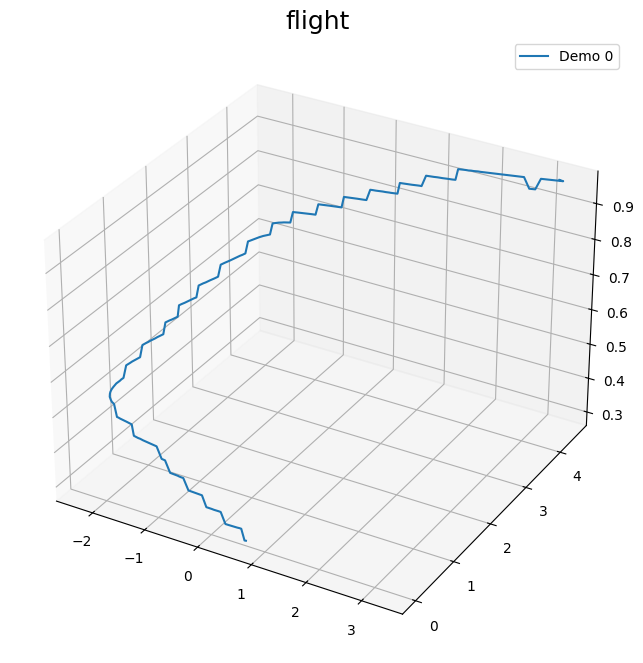

In [8]:
trajectories = []
for data_path in glob("7days1/processed_data/*/*.txt"):
    data = map(lambda x: ssv_to_ndarray(x), load_txt(data_path))
    data = np.stack(list(data))[:, 2:5]
    trajectories.append(data)

diff_filter = DiffFilter()
ground_filter = GroundFilter(0.3)

trajectories = list(filter(ground_filter, filter(diff_filter, trajectories)))
plot_trajectories(
    title="flight",
    trajectories=trajectories[54][None],
    legend=True,
)

Select one trajectory and generate similar ones based on the selected one   

(<Figure size 1000x800 with 1 Axes>, <Axes3D: title={'center': 'flight'}>)

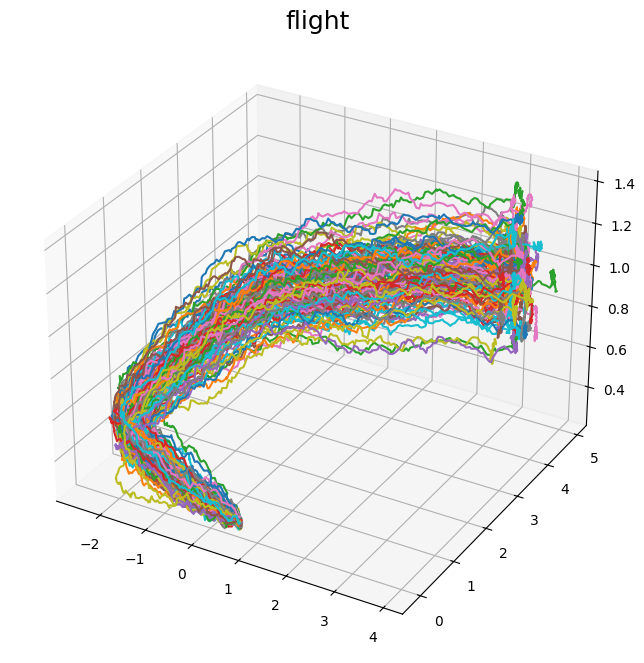

In [9]:
trajectory = trajectories[54]  # start trajectory

trajectory_vector = np.diff(trajectory, axis=0)

synthetic_trajectories = []
num_trajectories = 120
for _ in range(num_trajectories):
    synthetic_trajectory = np.zeros_like(trajectory) 
    noise = np.random.normal(0, 0.01, size=synthetic_trajectory.shape)
    synthetic_trajectory[0] = trajectory[0] + noise[0]
    for traj_idx in range(1, len(trajectory)):
        traj_point = synthetic_trajectory[traj_idx - 1] + trajectory_vector[traj_idx - 1] + noise[traj_idx]
        synthetic_trajectory[traj_idx] = traj_point
    synthetic_trajectories.append(np.stack(synthetic_trajectory))
# noise = np.random.normal(0, 0.5,)

plot_trajectories(
    title="flight",
    trajectories=synthetic_trajectories,
    legend=False,
)

In [10]:
trajectories = synthetic_trajectories

Preprocess data with following requirements.

- Trajectories have to have all the same length
- Transform into start position
- Transform into end position
- If not provided add time vector


In [11]:
from enum import Enum
from typing import Any, List, Literal, Union
from scipy import interpolate

from numpy import ndarray


class SamplingMode(Enum):
    MIN = 0
    MEAN = 1
    MAX = 2


class PreProcessor:
    def __init__(
        self,
        capture_frequency: float,
        num_samples: Union[
            Literal[SamplingMode.MAX],
            Literal[SamplingMode.MEAN],
            Literal[SamplingMode.MIN],
            int,
        ] = SamplingMode.MIN,
        frame_idx: List[int] = [0, -1],
    ) -> None:
        self.capture_frequency = capture_frequency
        self.num_samples = num_samples
        self.frame_idx = frame_idx  # determine from which frames inside the trajectory are determined to be reference frames for the GMR

    def __call__(self, data: Union[List[ndarray], ndarray]) -> ndarray:
        """_summary_

        Args:
            data (Union[List[ndarray], ndarray]): shape: (num_trajectories, num_points, num_features)
                num_trajectories: number of recorded and loaded trajectories
                num cluster points refers to the number of points inside a point framework like hand-landmarks (num_cluster_points = 21) from google mediapipe

        Returns:
            ndarray: shape: (num_trajectories, num_frames, num_points, num_features) num features contains x, y, z and time
        """
        trajectories = self.unify_length(data, self.num_samples)
        
        # translate trajectories into respected start and end frames with a constant rotation matrix
        local_trajectories = self.translate_trajectories(trajectories)

        # add capture time information
        local_trajectories = self.add_time(local_trajectories)

        # local_trajectories = np.concatenate(local_trajectories, axis=1)
        return local_trajectories
    
    def unify_length(self, 
        trajectories: List[ndarray],
        sampling_mode: Union[
            Literal[SamplingMode.MIN],
            Literal[SamplingMode.MAX],
            Literal[SamplingMode.MEAN],
            int,
        ] = SamplingMode.MIN,
    ) -> ndarray:
        """Normalize all the demos list and put all the values together in an unique
        ndarray: UNDERSAMPLING

        Args:
            demos (List[ndarray]): list of demonstration data. Each list element is a demonstration (ndarray).
            A demonstration element is a ndarray with shape (len_demo, num_features). Assumption num_features is greater equal 3 -> first
            indices: x, y, z information
            sampling_mode (SamplingMode, optional): _description_. Defaults to SamplingMode.UNDERSAMPLING.

        Raises:
            NotImplementedError: if sampling_mode is not equal SamplingMode.UNDERSAMPLING

        Returns:
            ndarray: all trajectories interpolated to the same length. Shape: (num_trajectories, num_points, 3). Last dimension is x, y, z
        """
        num_samples = None
        trajectoriy_lengths = map(lambda x: len(x), trajectories)
        if sampling_mode == SamplingMode.MIN:
            num_samples = min(trajectoriy_lengths)
        elif sampling_mode == SamplingMode.MEAN:
            num_samples = int(np.mean(trajectoriy_lengths))
        elif sampling_mode == SamplingMode.MAX:
            num_samples = max(trajectoriy_lengths)
        elif isinstance(sampling_mode, int):
            num_samples = sampling_mode

        unified_trajectories = []
        for trajectory in trajectories:
            # create splines and sample points from the spline to get a uniform length of each trajectory
            tck, u = interpolate.splprep(trajectory[:, :3].T, k=3, s=0)
            u = np.linspace(0, 1, num=num_samples, endpoint=True)
            unified_trajectories.append(interpolate.splev(u, tck))

        unified_trajectories = np.stack(unified_trajectories).swapaxes(-1, -2)

        return unified_trajectories

    def translate_trajectories(self, trajectories: ndarray, ) -> ndarray:
        # get pick and place translation from trajectories as first and last position
        start_end_translation = trajectories[:, [0, -1], :]
        means = start_end_translation.mean(0)
        print("mean start: ", means[0])
        print("mean end: ", means[1])
        result = np.empty((2, *trajectories.shape))
        for frame_idx in range(2):
            points = trajectories.swapaxes(0, 1) - start_end_translation[:, frame_idx] 
            result[frame_idx] = points.swapaxes(0, 1)
        
        return result

    def add_time(
        self, trajectories: Union[List[ndarray], ndarray]) -> Union[List[ndarray], ndarray]:
        """adds to every point on the trajectory its recorded timestamp with the assumption all trajectories started at t = 0

        Args:
            trajectories (Union[List[ndarray], ndarray]): trajectories. Shape: (...., num_points, 3)
            freq (float): recording frequency

        Returns:
            Union[List[ndarray]: trajectories with time information. Shape (..., num_points, 4). Last dimension is (x, y, z, time)
        """

        if isinstance(trajectories, ndarray):
            # create time vector
            traj_shape = trajectories.shape
            # ASSUMPTION: values at index: -2 = num_points

            time = np.arange(
                0,
                traj_shape[-2] * (1 / self.capture_frequency),
                1 / self.capture_frequency,
            )
            print(f"time feature between {time[0]} and {time[-1]}. {len(time)} time instances")

            # bump up dimensionality to match trajectories
            time = time.reshape((1,) * 2 + (-1, 1))
            time = np.broadcast_to(time, (*traj_shape[:-1], 1))

            return np.concatenate([trajectories, time], axis=-1)

        else:
            raise ValueError("wrong input type. Supported is: ndarray")
        

num_samples = 200
capture_freq = 100
pre_processor = PreProcessor(capture_freq, num_samples)

pre_processed_data = pre_processor(trajectories)
# plot_trajectories(trajectories=pre_processed_data[0, [15]])



mean start:  [ 0.64806996 -0.00095385  0.2748303 ]
mean end:  [3.23917965 4.46898173 0.99668455]
time feature between 0.0 and 1.99. 200 time instances


In [12]:
import time
from typing import Any, Dict, Tuple

import numpy as np
import torch
from torch import Tensor
from numpy import ndarray
from sklearn import metrics
from sklearn.cluster import KMeans
import itertools

from tpgmm.utils.learning_modules import ClassificationModule
from tpgmm.utils.arrays import identity_like
from tpgmm.utils.stochastic import multivariate_gauss_cdf
from scipy.stats import multivariate_normal


class TPGMM(ClassificationModule):
    """
    This class in an implementation of the task parameterized gaussian mixture model according to Calinon Paper @https://calinon.ch/papers/Calinon-JIST2015.pdf

    It implements also an Expectation Maximization Algorithm with:  \n
    E-Step:
    \f[
        h_{t, i} = \frac{\pi_i \prod_{j=1}^P \mathcal{N}\left(X_t^{(j)} \mid \mu_i^{(j)}, \Sigma_i^{(j)}\right)}{\sum_{k=1}^K \pi_k \prod_{j=1}^P \mathcal{N}\left(X_t^{(j)} \mid \mu_k^{(j)}, \Sigma_k^{(j)}\right)}
    \f]

    M-Step:
    \f[
        \pi_i \leftarrow \frac{\sum_{t=1}^N h_{t, i}}{N}
    \f]
    \f[
        \mu_i^{(j)} \leftarrow \frac{\sum_{t=1}^N h_{t, i} X_t^{(j)}}{\sum_{t=1}^N h_{t, i}}
    \f]
    \f[
        \Sigma_i^{(j)} \leftarrow \frac{\sum_{t=1}^N h_{t, i} \left(X_t^{(j)} - \mu_i^{(j)}\right)\left(X_t^{(j)} - \mu_i^{(j)}\right)^T}{\sum_{t=1}^N h_{t, i}}
    \f]

    The optimization criterion is the log-likelihood implemented with:
    \f[
        LL = \frac{\sum_{t=1}^N \log\left(\sum_{k=1}^K \pi_k \prod_{j=1}^J\mathcal{N}\left(X_t^{(j)} \mid \mu_k^{(j)}, \Sigma_k^{(j)}\right)\right)}{N}
    \f]

    Variable explanation:\n
    \f$N\f$ ... number of components\n
    \f$\pi\f$ ... weights between components\n
    \f$i\f$ ... component index\n
    \f$j\f$ ... frame index (like pick or place frame)\n
    \f$\mu\f$ ... mean\n
    \f$\Sigma\f$ ... variance / covariance matrix\n
    \f$LL\f$ ... log likelihood

    Examples:
    >>> trajectories = load_trajectories()  # trajectory data in local reference frames with shape: (num_reference_frames, num_points, 3)
    >>> tpgmm = TPGMM(n_components=5)
    >>> tpgmm.fit(trajectories)

    Args:
        n_components (int): number of components
        tol (float): threshold to break from EM algorithm. Defaults to 1e-3.
        max_iter (int): maximum number of iterations to perform the expectation maximization algorithm. Defaults to 100.
        min_iter (int): minimum number of iterations to perform the expectation maximization algorithm. Defaults to 5.
        weights_init (ndarray): initial weights between each component. If set replaces initialization from K-Means. Defaults to None.
        means_init (ndarray): initial means between each component. If set replaces initialization from K-Means. Defaults to None.
        reg_factor (float): regularization factor for empirical covariance matrix. Defaults to 1e-5.
        verbose (bool): Triggers print of learning stats. Defaults to False.

    Attributes:
        weights_: ndarray of shape (n_components,) Weights between gaussian components.
        means_: ndarray of shape (num_frames, n_components, num_features) Mean matrix for each frame and component.
        covariances_: ndarray of shape (num_frames, n_components, num_features, num_features). Covariance matrix for each frame and component
    """

    def __init__(
        self,
        n_components: int,
        threshold: float = 1e-7,
        max_iter: int = 100,
        min_iter: int = 5,
        weights_init: Tensor = None,
        means_init: Tensor = None,
        reg_factor: float = 1e-5,
        verbose: bool = False,
    ) -> None:
        """
        Initialize the TPGMM class.

        Args:
            n_components (int): Number of Gaussian multidimensional distributions to mix.
            threshold (float): Threshold to break from EM algorithm. Defaults to 1e-3.
            max_iter (int): Maximum number of iterations to perform the expectation maximization algorithm. Defaults to 100.
            min_iter (int): Minimum number of iterations to perform the expectation maximization algorithm. Defaults to 5.
            weights_init (Tensor): Initial weights between each component. If set, it replaces initialization from K-Means. Defaults to None.
            means_init (Tensor): Initial means between each component. If set, it replaces initialization from K-Means. Defaults to None.
            reg_factor (float): Regularization factor for the empirical covariance matrix. Defaults to 1e-5.
            verbose (bool): Triggers print of learning stats. Defaults to False.
        """
        super().__init__(n_components)
        self._max_iter = max_iter
        self._min_iter = min_iter
        self._threshold = threshold
        self._reg_factor = reg_factor
        self._verbose = verbose

        self._k_means_algo = KMeans(
            n_clusters=self._n_components, init="k-means++", n_init="auto"
        )
        """KMeans: algorithm to initialize unsupervised clustering"""
        self._cov_reg_matrix = None
        """Tensor: to avoid singularities. shape: (num_frames, n_components, num_features, num_features)"""

        self.weights_ = weights_init
        """Tensor: Weights between gaussian mixture models shape: (n_components)"""

        self.means_ = means_init
        """Tensor: mean matrix for each frame and component: (num_frames, n_components, num_features)"""

        self.covariances_ = None
        """Tensor: covariance matrix for each frame and component. Shape: (num_frames, n_components, num_features, num_features)"""

    def fit(self, X: Tensor) -> None:
        """fits X on the task parameterized gaussian mixture model using K-Means clustering as default initialization method and executes the expectation maximization algorithm: \n
        E-Step:
        self._update_h()

        M-Step:
        self._update_weights_()
        self._update_means_()
        self._update_covariances()

        The optimization criterion is the log-likelihood implemented in:
        self._log_likelihood()

        The algorithm stops if \f$LL_{t-1} - LL_t < \textit{self.tol}\f$ with \f$LL_{t}\f$ as the log-likelihood at time t.

        Args:
            X (Tensor): data tensor to fit the the task parameterized gaussian mixture model on. Expected shape: (num_frames, num_points, num_features)
        """
        # perform k-means clustering
        if self._verbose:
            print("Started KMeans clustering")
        self.means_, self.covariances_ = self._k_means(X)
        self._cov_reg_matrix = identity_like(self.covariances_) * self._reg_factor

        if self._verbose:
            print("finished KMeans clustering")

        # init weights with uniform probability
        if self.weights_ is None:
            self.weights_ = torch.ones(self._n_components) / self._n_components

        if self._verbose:
            print("Start expectation maximization")

        probabilities = self.gauss_pdf(X)
        log_likelihood = self._log_likelihood(probabilities)
        for epoch_idx in range(self._max_iter):
            # Expectation
            h = self._update_h(probabilities)

            # Maximization
            self._update_weights(h)
            self._update_mean(X, h)
            self._update_covariances_(X, h)

            # update probabilities and log likelihood
            probabilities = self.gauss_pdf(X)
            updated_log_likelihood = self._log_likelihood(probabilities)

            # Logging
            difference = updated_log_likelihood - log_likelihood
            # print(updated_log_likelihood)
            if torch.isnan(torch.tensor(difference)):
                print(Warning("improvement is nan. Abort fit"))
                return False

            if self._verbose:
                print(
                    f"Log likelihood: {updated_log_likelihood} improvement {difference}"
                )

            # break if threshold is reached
            if (
                difference < self._threshold and epoch_idx >= self._min_iter
            ) or epoch_idx > self._max_iter:
                break

            log_likelihood = updated_log_likelihood

    def predict(self, X: Tensor) -> Tensor:
        """predict cluster labels for each data point in X

        Args:
            X (Tensor): data in local reference frames. Shape (num_frames, num_points, num_features)

        Returns:
            Tensor: the label for each data-point. Shape (num_points)
        """
        probabilities = self.predict_proba(X)
        labels = torch.argmax(probabilities, dim=1)
        return labels

    def predict_proba(self, X: Tensor) -> Tensor:
        """predict cluster labels for each data point

        Args:
            X (Tensor): data in local reference frames. Shape (num_frames, num_points, num_features)

        Returns:
            Tensor: cluster probabilities for each data_point. Shape: (num_points, num_components)
        """
        frame_probs = self.gauss_pdf(X)
        probabilities = torch.prod(frame_probs, dim=0).T
        return probabilities

    def silhouette_score(self, X: Tensor) -> float:
        """calculated the silhouette score of the model over the given metric and given data x

        Args:
            X (Tensor): data in expected shape: (num_frames, num_points, num_features)
            metric (str): _description_. Defaults to "euclidean".
        """
        labels = self.predict(X)
        scores = np.empty(X.shape[0])
        for frame_idx in range(X.shape[0]):
            scores[frame_idx] = metrics.silhouette_score(X[frame_idx].numpy(), labels.numpy())
        weights = self.weights_[:, None].repeat(1, X.shape[0])
        weighted_sum = (weights @ scores) / (self.weights_ * X.shape[0])
        return weighted_sum.mean()

    def score(self, X: Tensor) -> float:
        """calculate log likelihood score given data

        Args:
            X (Tensor): data tensor with expected shape (num_frames, num_points, num_features)

        Returns:
            float: log likelihood of given data
        """
        probabilities = self.gauss_pdf(X)
        score = self._log_likelihood(probabilities)
        return score

    def bic(self, X: Tensor) -> float:
        """calculates the bayesian information criterion as in

        https://scikit-learn.org/stable/modules/linear_model.html#aic-bic

        Args:
            X (Tensor): data tensor with expected shape (num_frames, num_points, num_features)

        Returns:
            float: bic score
        """
        num_points = X.shape[1]
        log_likelihood = self.score(X)
        bic = -2 * log_likelihood + np.log(num_points) * self._num_params()
        return bic

    def aic(self, X: Tensor) -> float:
        """calculates the akaike information criterion as in

        https://scikit-learn.org/stable/modules/linear_model.html#aic-bic

        Args:
            X (Tensor): data tensor with expected shape (num_frames, num_points, num_features)

        Returns:
            float: aic score
        """
        log_likelihood = self.score(X).numpy()
        bic = -2 * log_likelihood + 2 * self._num_params()
        return bic

    def gauss_pdf(self, X: Tensor) -> Tensor:
        """calculate the gaussian probability for a given data set.
        \f[
            \mathcal{N}\left(X_t^{(j)} \mid \mu_i^{(j)}, \Sigma_i^{(j)}\right) = \frac{1}{\sqrt{(2\pi)^D|\Sigma_i^{(j)}|}} \exp \left( \frac{1}{2}(X_t^{(j)} - \mu_i^{(j)})\Sigma_i^{(j), -1}(X_t^{(j)} - \mu_i^{(j)})^T\right)
        \f]

        Variable explanation:
        D ... number of features

        Args:
            X (Tensor): data with shape: (num_frames, num_points, num_features)

        Returns:
            Tensor: probability shape (num_frames, n_components, num_points)
        """
        num_frames, num_points, _ = X.shape
        probs = torch.empty((num_frames, self._n_components, num_points))
        # to prevent singularity matrices
        covariances = self.covariances_ + self._cov_reg_matrix
        for frame_idx, component_idx in itertools.product(
            range(num_frames), range(self._n_components)
        ):
            frame_data = X[frame_idx]
            cluster_mean = self.means_[frame_idx, component_idx]
            cluster_cov = covariances[frame_idx, component_idx]
            distr = torch.distributions.MultivariateNormal(cluster_mean, cluster_cov)
            probs[frame_idx, component_idx] = torch.exp(distr.log_prob(frame_data))
            # probs[frame_idx, component_idx] = multivariate_normal.pdf(
            #     frame_data, cluster_mean, cluster_cov
            # )
        return probs

    @property
    def config(self) -> Dict[str, Any]:
        """
        Returns a dictionary containing the configuration parameters of the TPGMM model.

        Returns:
            Dict[str, Any]: Dictionary containing the configuration parameters.
        """
        config = {
            "max_iter": self._max_iter,
            "min_iter": self._min_iter,
            "threshold": self._threshold,
            "reg_factor": self._reg_factor,
        }

        config = {**config, **super().config}
        return config

    def _num_params(self) -> int:
        """computes the number of parameters the model has internally
        This means it is the sum of:
        - num_frames * num_components (mean)
        - num_frames * num_components * (num_components + 1) // 2 (covariances)
        - num_components - 1 (weights)

        Returns:
            int: number of parameters of TPGMM
        """
        num_frames = 2

        num_mean_params = self._n_components * num_frames
        num_cov_params = num_frames * self._n_components * (self._n_components + 1) // 2
        num_weight_params = self._n_components - 1
        num_params = num_mean_params + num_cov_params + num_weight_params
        return num_params
    
    def _k_means(
        self,
        X: Tensor,
    ) -> Tuple[Tensor, Tensor]:
        """calculate k means clustering on each frame and calculates the
            empirical covariance matrix for each cluster.

        For more details on k means clustering algorithm please refer to: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

        Args:
            X (Tensor): data in feature space for k means clustering.
                shape: (num_frames, num_points, num_features)

        Returns:
            Tuple[Tensor, Tensor]:
             - means with shape: (num_frames, n_components, num_features)
             - covariance matrix with shape: (num_frames, n_components, num_features, num_features)
        """
        num_frames, _, num_features = X.shape
        means = torch.empty((num_frames, self._n_components, num_features))
        covariances = torch.empty(
            (num_frames, self._n_components, num_features, num_features)
        )
        for frame_idx, frame_data in enumerate(X):
            self._k_means_algo.fit(frame_data.detach().numpy())
            # get mean
            means[frame_idx] = torch.from_numpy(self._k_means_algo.cluster_centers_)
            for cluster_idx in range(self._n_components):
                data_idx = np.argwhere(
                    self._k_means_algo.labels_ == cluster_idx
                ).squeeze()
                covariances[frame_idx, cluster_idx] = torch.from_numpy(
                    np.cov(frame_data[data_idx].T)
                )

        # regularization
        reg_matrix = identity_like(covariances) * self._reg_factor
        covariances += reg_matrix
        return means, covariances

    def _update_h(self, probabilities: Tensor) -> Tensor:
        """update h parameter according to equation 49 in appendix 1
        \f[
            h_{t, i} = \frac{\pi_i \prod_{j=1}^P \mathcal{N}\left(X_t^{(j)} \mid \mu_i^{(j)}, \Sigma_i^{(j)}\right)}{\sum_{k=1}^K \pi_k \prod_{j=1}^P \mathcal{N}\left(X_t^{(j)} \mid \mu_k^{(j)}, \Sigma_k^{(j)}\right)}
        \f]

        Args:
            data (Tensor): shape: (num_frames, num_points, num_features)
            probabilities (Tensor): shape (num_frames, n_components, num_points)
        Returns:
            Tensor: h-parameter. shape: (n_components, num_points)
        """
        cluster_probs = torch.prod(
            probabilities, dim=0
        )  # shape: (n_components, num_points)
        numerator = (
            self.weights_ * cluster_probs.T
        ).T  # shape: (n_components, num_points)
        denominator = torch.sum(numerator, dim=0)  # shape: (num_points)
        h = numerator / denominator
        h[numerator == 0] = 0
        return h

    def _update_weights(self, h: Tensor) -> None:
        """update pi (weights parameter according to equation 50).
        \f[
            \pi_i \leftarrow \frac{\sum_{t=1}^N h_{t, i}}{N}
        \f]

        Args:
            h (Tensor): shape: (n_components, num_points)
        """
        self.weights_ = torch.mean(h, dim=1)

    def _update_mean(self, X: Tensor, h: Tensor) -> None:
        """updates the mean parameter according to equation 51.
        \f[
            \mu_i^{(j)} \leftarrow \frac{\sum_{t=1}^N h_{t, i} X_t^{(j)}}{\sum_{t=1}^N h_{t, i}}
        \f]

        Args:
            X (Tensor): shape: (num_frames, num_points, num_features)
            h (Tensor): shape: (n_components, num_points)
        """
        num_frames, _, num_features = X.shape
        # reshape X into -> (num_frames, num_components, num_points, num_features)
        X = X[:, None].repeat(1, self._n_components, 1, 1)
        # reshape h into -> (num_frames, num_components, num_points, num_features)
        h = h[None, ..., None].repeat(num_frames, 1, 1, num_features)
        
        numerator = torch.sum(h * X, dim=2)
        denominator = torch.sum(h, dim=2)
        means = numerator / denominator
        means[numerator == 0] = 0
        self.means_ = means

    def _update_covariances_(self, X: Tensor, h: Tensor) -> None:
        """updates the covariance parameter according to equation 52
        \f[
            \Sigma_i^{(j)} \leftarrow \frac{\sum_{t=1}^N h_{t, i} \left(X_t^{(j)} - \mu_i^{(j)}\right)\left(X_t^{(j)} - \mu_i^{(j)}\right)^T}{\sum_{t=1}^N h_{t, i}}
        \f]

        Args:
            X (Tensor): shape: (num_frames, num_points, num_features)
            h (Tensor): shape: (n_components, num_points)
        """
        x_centered = X[..., None, :] - self.means_[:, None]
        prod = torch.einsum("ijkh,ijkl,kj->ikhl", x_centered.float(), x_centered.float(), h)
        cov = prod / h.sum(dim=1)[None, :, None, None]
        cov[prod == 0.0] = 0.0

        self.covariances_ = cov

    def _log_likelihood(self, densities: Tensor) -> float:
        """calculates the log likelihood of given densities
        \f[
            LL = \frac{\sum_{t=1}^N \log\left(\sum_{k=1}^K \pi_k \prod_{j=1}^J\mathcal{N}\left(X_t^{(j)} \mid \mu_k^{(j)}, \Sigma_k^{(j)}\right)\right)}{N}
        \f]

        Args:
            densities (Tensor): shape: (num_frames, n_components, num_points)

        Returns:
            float: log likelihood
        """
        densities = torch.prod(densities, dim=0)
        weighted_sum = self.weights_ @ densities   # shape (num_points)
        # stabilize training by replaying a small constant to 
        weighted_sum += torch.ones_like(weighted_sum) * 1e-18 
        ll = torch.sum(torch.log(weighted_sum)).item()
        return ll

In [227]:

num_trajectories = pre_processed_data.shape[1]
concatenated_trajectories = np.reshape(
    pre_processed_data, (2, num_trajectories * num_samples, 4)
)
concatenated_trajectories = torch.from_numpy(concatenated_trajectories)

torch.manual_seed(100)
np.random.seed(123)

K = np.arange(3, 30)
num_trials = 5

BIC = np.empty((num_trials, len(K))) * np.nan

for idx, num_cluster in enumerate(tqdm(K)):
    for trial_idx in range(num_trials):
        tpgmm = TPGMM(num_cluster, reg_factor=1e-3)
        tpgmm.fit(concatenated_trajectories)
        BIC[trial_idx, idx] = tpgmm.bic(concatenated_trajectories)

100%|██████████| 27/27 [21:07<00:00, 46.95s/it]


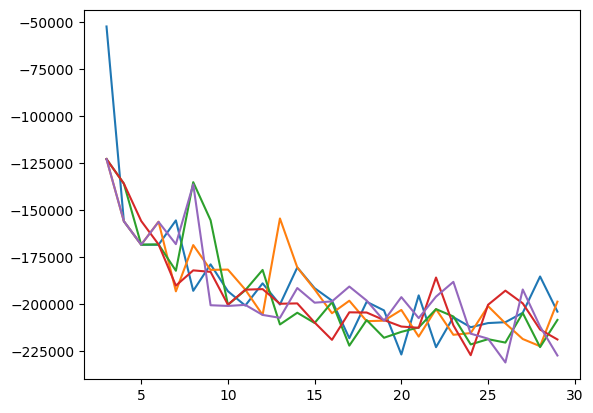

In [229]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(K, BIC.T)

In [13]:
tpgmm = TPGMM(25)
num_trajectories = pre_processed_data.shape[1]
concatenated_trajectories = np.reshape(
    pre_processed_data, (2, num_trajectories * num_samples, 4)
)

tpgmm.fit(torch.from_numpy(concatenated_trajectories))

/home/robin/projects/TaskParameterizedGaussianMixtureModels/tpgmm/utils/plot/plot.py:99: RuntimeWarning: invalid value encountered in sqrt
  ellipsoid = np.dot(ellipsoid, np.sqrt(np.diag(eigenvalues))) @ eigenvectors.T


(<Figure size 1000x800 with 1 Axes>,
 <Axes3D: title={'center': 'GMM from end perspective'}>)

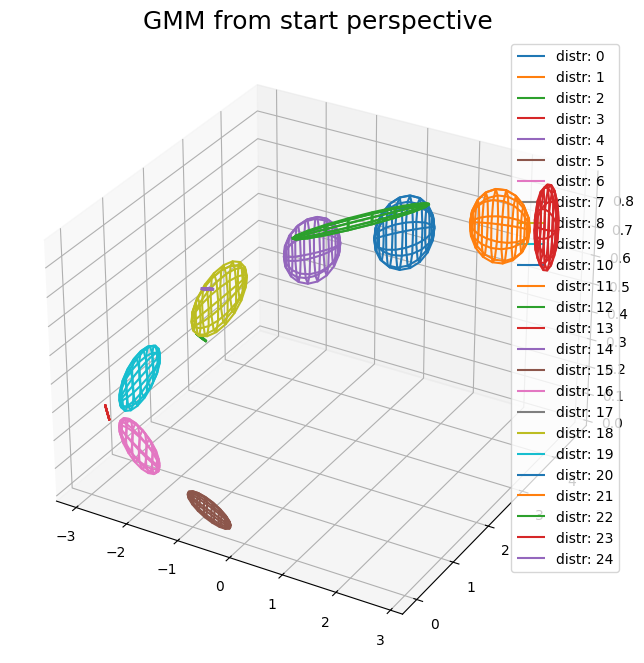

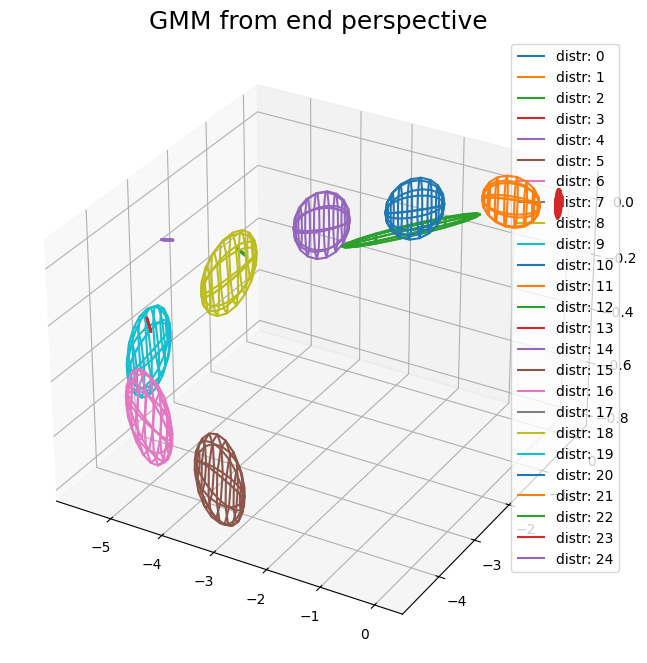

In [14]:
from tpgmm.gmr.gmr import GaussianMixtureRegression
from tpgmm.utils.plot.plot import plot_ellipsoids

frame_idx = 0
plot_ellipsoids(
    title="GMM from start perspective",
    means=tpgmm.means_[frame_idx, :, :3].numpy(),
    covs=tpgmm.covariances_[frame_idx, :, :3, :3].numpy(),
    legend=True,
)
frame_idx = 1
plot_ellipsoids(
    title="GMM from end perspective",
    means=tpgmm.means_[frame_idx, :, :3].numpy(),
    covs=tpgmm.covariances_[frame_idx, :, :3, :3].numpy(),
    legend=True,
)

In [12]:
gmr = GaussianMixtureRegression.from_tpgmm(tpgmm, [3])

translation = np.array(
    [[0.67434406, -0.10956558, 0.31207092], [1.52133899, 0.03424608, 0.40956669]]
)
translation = np.array([[ 0.64892812, -0.00127319,  0.27268653], [3.25658728, 4.49575041, 0.95660171]])
rotation_matrix = np.eye(3)[None].repeat(2, axis=0)
gmr.fit(translation=translation, rotation_matrix=rotation_matrix)

Distance to desired positions:
 start: 0.013276134271923881 
 end: 0.0022635617310432284


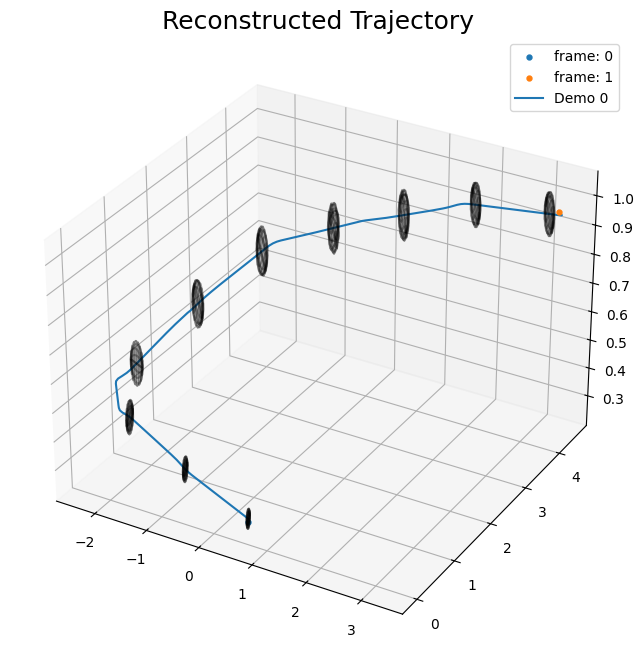

In [13]:
from tpgmm.utils.plot.plot import scatter


input_data = np.linspace(0, 2, 200)[:, None]
mu, cov = gmr.predict(input_data)

fig, ax = scatter(title="Reconstructed Trajectory", data=translation[: ,None])
fig, ax = plot_trajectories(trajectories=mu[None], fig=fig, ax=ax, legend=True)
plot_ellipsoids(
    means=mu[::20], covs=cov[::20], fig=fig, ax=ax, color="k", alpha=0.3
)
print(f"Distance to desired positions:\n start: {np.linalg.norm(translation[0] - mu[0])} \n end: {np.linalg.norm(translation[1] - mu[-1])}")